In [18]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn 
import torch.nn.functional as F 
import torch.distributions.normal as tdn
from sbi import inference
from sbi.inference import SNPE, simulate_for_sbi, prepare_for_sbi
import warnings
warnings.filterwarnings('ignore')

# set seed for numpy and torch
seed = 769
np.random.seed(seed)
torch.manual_seed(seed)

### Prior ~ N(mean=0, var=25)

In [20]:
prior_parameter = torch.tensor([0.0]), torch.tensor([5.0])
prior = tdn.Normal(prior_parameter[0], prior_parameter[1])

In [21]:
prior.sample((100000,)).shape

torch.Size([100000, 1])

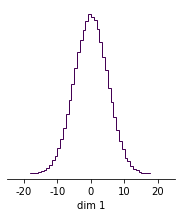

In [22]:
samples = 100000
samples = prior.sample((samples,))
_ = analysis.pairplot(samples, limits=[[-25,25]], figsize=(3,3))

In [23]:
print("mean of prior : {:.3f}".format(torch.mean(samples).item()))
print("variance of prior : {:.3f}".format(torch.var(samples).item()))

mean of prior : -0.033
variance of prior : 24.927


In [24]:
prior_parameter1 = torch.tensor([0.0]), torch.tensor([1.0])
prior1 = tdn.Normal(prior_parameter1[0], prior_parameter1[1])

In [25]:
prior_parameter2 = torch.tensor([0.0]), torch.tensor([2.0])
prior2 = tdn.Normal(prior_parameter2[0], prior_parameter2[1])

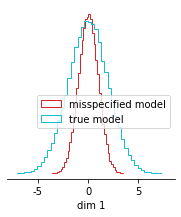

In [26]:
samples = 100000
samples_1 = prior1.sample((samples,))
samples_2 = prior2.sample((samples,))
fig, ax = analysis.pairplot([samples_1,samples_2], samples_colors = ['#d62728','#17becf'], figsize=(3,3))
plt.legend(["misspecified model","true model"],loc='upper right', bbox_to_anchor=(0.5, 0., 0.5, 0.5))

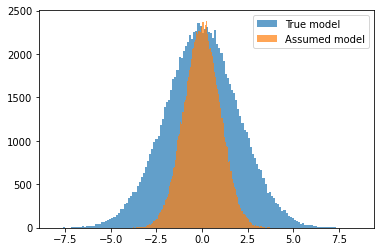

In [27]:
plt.hist(np.array(samples_2), bins="auto", label="mean", alpha=0.7)
plt.hist(np.array(samples_1), bins="auto", label="mean_true_sim", alpha=0.7)
plt.legend(["True model", "Assumed model"])
plt.show()

### Assumed (wrong) model ~ N(mean=theta, var=1)

In [28]:
def assumed_simulator(theta, std=1, num_iid_samples=50):
    batch_size, num_dims = theta.shape
#     dist = tdn.Normal(theta, std)
    dist = torch.distributions.MultivariateNormal(loc=theta, covariance_matrix=torch.eye(num_dims) * std)
  # should have shape (batch_size, num_dims, num_iid_samples) or similar
    samples = dist.sample((num_iid_samples,))
  # take mean and var over iid dimension.
    mean, var = torch.mean(samples, axis=0), torch.var(samples, axis=0)
    return torch.cat([mean, var], axis=1)

### True model ~ N(mean=theta, var=16) 

#### var to be varied from 1 to 25

In [29]:
def true_simulator(theta, variance=16.0, num_iid_samples=50):
    dist = tdn.Normal(theta, np.sqrt(variance + 4)/3)
    samples = dist.sample((num_iid_samples,))
    mean, var = torch.mean(samples), torch.var(samples)
    return dist, mean, var

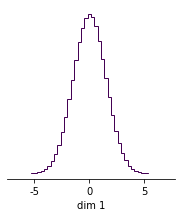

In [30]:
samples = 10000000
samples = true_simulator(torch.tensor([0.0]))[0].sample((samples,))
_ = analysis.pairplot(samples, figsize=(3,3))

In [31]:
print("mean of prior : {:.3f}".format(torch.mean(samples).item()))
print("variance of prior : {:.3f}".format(torch.var(samples).item()))

mean of prior : 0.001
variance of prior : 2.221


### True Posterior Calculations

**Likelihood ~ (2/3) N(th0,1.0)+(1/3) N(th0,std^2)  
Prior ~ N(0,25)**

In [32]:
def true_posterior(mean, variance=4.0, num_iid_samples=50):
    l_mean = mean
    l_var = (((2/3)**2)+(variance/9))/num_iid_samples
#     print(l_var)
    p_mean = 0.0
    p_var = 25.0
    mean = (l_var*p_mean + p_var*l_mean) / (l_var + p_var)
    var = 1 / (1/l_var + 1/p_var)
    dist = tdn.Normal(torch.tensor([mean]), torch.tensor([np.sqrt(var)]))
    return dist, mean, var

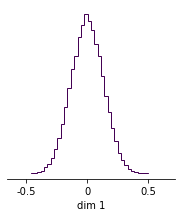

In [33]:
samples = 100000
samples = true_posterior(torch.tensor([0.0]))[0].sample((samples,))
_ = analysis.pairplot(samples, figsize=(3,3))

In [34]:
x0 = true_simulator(torch.tensor([0.0]))[0].sample((1,))
_, mean, var = true_posterior(x0)
print("mean of prior : {:.3f}".format(mean.item()))
print("variance of prior : {:.3f}".format(var))

mean of prior : -1.227
variance of prior : 0.018


### Posterior Inference

In [35]:
simulator_wrapper, prior = prepare_for_sbi(assumed_simulator, prior)

In [36]:
theta, x = simulate_for_sbi(simulator_wrapper, prior, num_simulations=10000)

Running 10000 simulations.:   0%|          | 0/10000 [00:00<?, ?it/s]

In [37]:
theta.shape, x.shape

(torch.Size([10000, 1]), torch.Size([10000, 2]))

In [38]:
true_mean_samples = []
true_var_samples = []
points_list = []
i=1
for i in range(10000):
    _, mean, var = true_simulator(prior.sample((1,)), 25.0)
    true_mean_samples.append(mean)
    true_var_samples.append(var)
    points_list.append((i**2 + 4)/9)

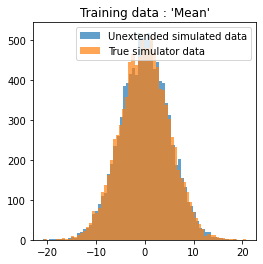

In [39]:
plt.figure(figsize=(4,4))
plt.hist(x[:10000, 0].numpy(), bins="auto", label="mean", alpha=0.7)
plt.hist(np.array(true_mean_samples), bins="auto", label="mean_true_sim", alpha=0.7)
plt.title("Training data : 'Mean'")
plt.legend(["Unextended simulated data", "True simulator data"])
plt.show()

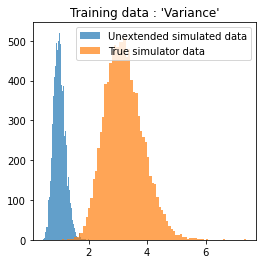

In [40]:
plt.figure(figsize=(4,4))
plt.hist(x[:10000, 1].numpy(), bins="auto", label="mean", alpha=0.7)
plt.hist(np.array(true_var_samples), bins="auto", label="mean_true_sim", alpha=0.7)
plt.title("Training data : 'Variance'")
plt.legend(["Unextended simulated data", "True simulator data"])
plt.show()

In [42]:
inference = SNPE(prior=prior)

In [43]:
inference = inference.append_simulations(theta, x)

In [44]:
density_estimator = inference.train()

Neural network successfully converged after 150 epochs.


In [45]:
posterior = inference.build_posterior(density_estimator)

In [46]:
th0 = torch.tensor([[0.0]])
obs_list = []
sample_list = []
th_list = []
probs_list = []
var_list = []
posterior_mean = []
posterior_var = []
i=1
while i < 5:
    _, mean, var = true_simulator(th0, i**2)
    samples = posterior.sample((10000,), x=[mean, var])
    sample_list.append(samples)
    obs_list.append(mean)
    th_list.append(th0)
    var_list.append(i**2)
    _, mean, var = true_posterior(mean, i**2)
    posterior_mean.append(mean.item())
    posterior_var.append(var)
    i+=0.1

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

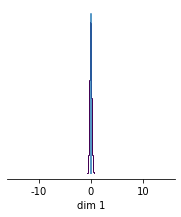

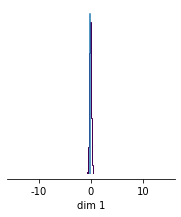

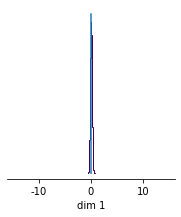

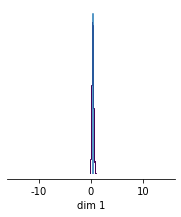

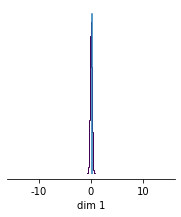

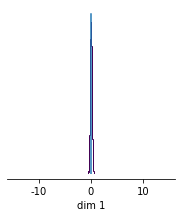

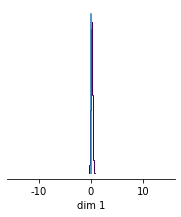

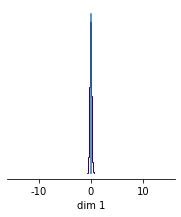

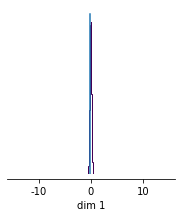

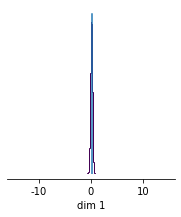

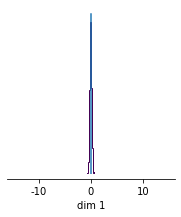

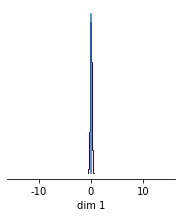

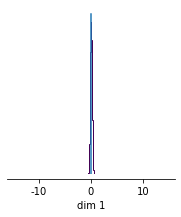

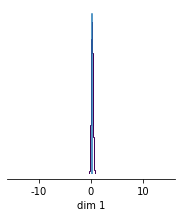

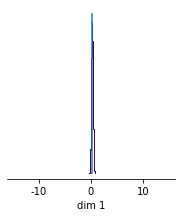

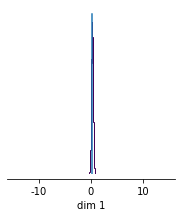

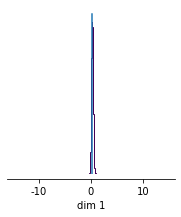

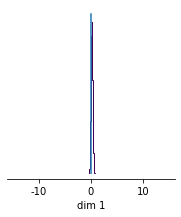

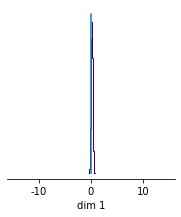

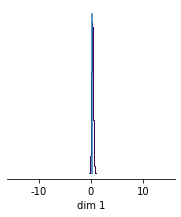

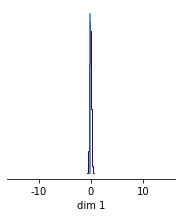

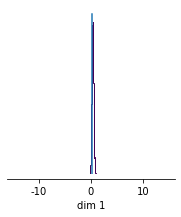

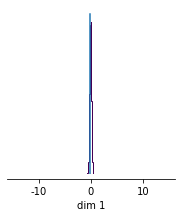

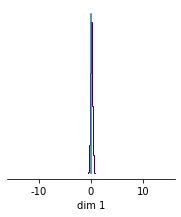

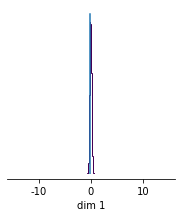

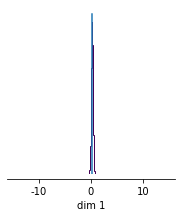

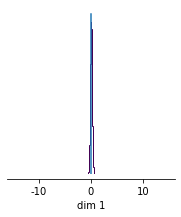

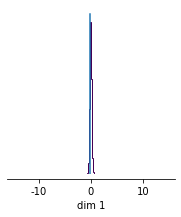

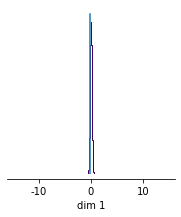

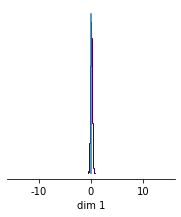

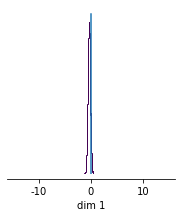

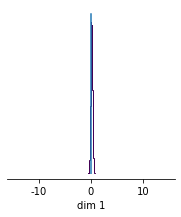

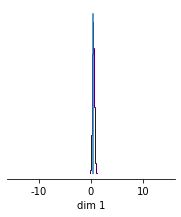

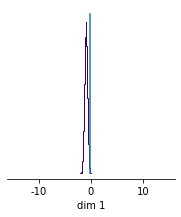

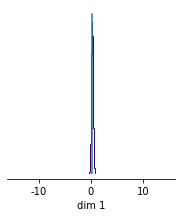

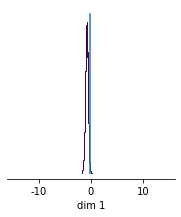

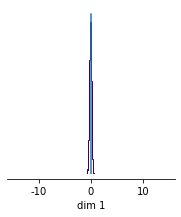

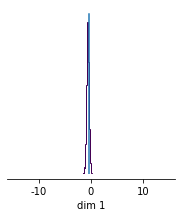

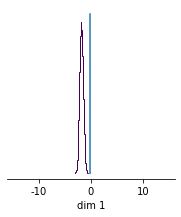

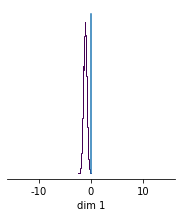

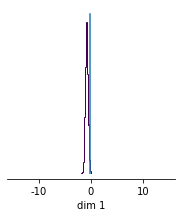

In [47]:
for i in range(len(sample_list)):
    _ = analysis.pairplot(sample_list[i], points=posterior_mean[i], limits=[[-16,16]], figsize=(3,3))

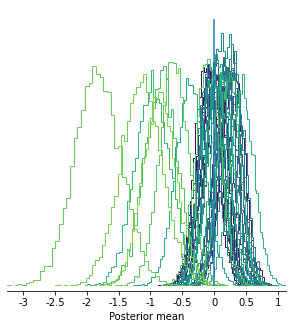

In [54]:
_ = analysis.pairplot(sample_list,points=th0, labels=['Posterior mean'],
                      figsize=(5,5))

In [49]:
sample_mean = np.mean(sample_list, axis=1)
sample_var = np.var(sample_list, axis=1)

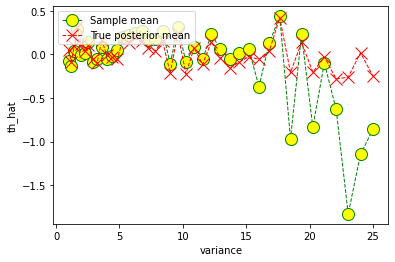

In [51]:
plt.plot(var_list, sample_mean, color='green', linestyle='dashed', linewidth = 1,
         marker='o', markerfacecolor='yellow', markersize=12)
plt.plot(var_list,posterior_mean, color='red', linestyle='dashed', linewidth = 1,
         marker='x', markerfacecolor='black', markersize=12)
plt.xlabel("variance")
plt.ylabel("th_hat")
plt.legend(["Sample mean", "True posterior mean"], loc ="upper left")
plt.show()

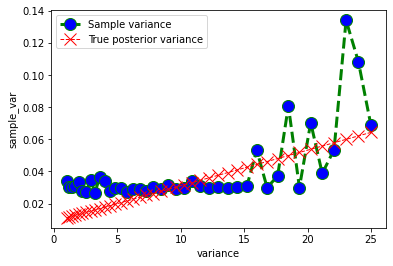

In [52]:
plt.plot(var_list, sample_var, color='green', linestyle='dashed', linewidth = 3,
         marker='o', markerfacecolor='blue', markersize=12)
plt.plot(var_list,posterior_var, color='red', linestyle='dashed', linewidth = 1,
         marker='x', markerfacecolor='black', markersize=12)
plt.xlabel("variance")
plt.ylabel("sample_var")
plt.legend(["Sample variance", "True posterior variance"], loc ="upper left")
plt.show()

### Posterior Predictive Check

Mean = -4.259, Variance = 3.570


Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

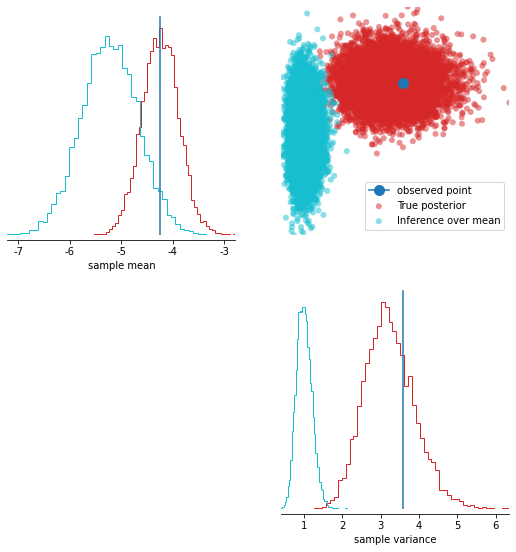

In [66]:
num_simulations = 10000
_, mean0, var0 = true_simulator(prior.sample((1,)), 25.0)
print("Mean = {:.3f}, Variance = {:.3f}".format(mean0, var0))
samples1 = posterior.sample((num_simulations,), x=[mean0,var0])
samp3 = true_posterior(mean0,25.0)[0].sample((num_simulations,))
a = assumed_simulator(samples1)
p = np.stack([mean0, var0])
mean_samples = []
var_samples = []
for param in samp3:
    _, mean, var = true_simulator(param, 25.0)
    mean_samples.append(mean)
    var_samples.append(var)
mean_samples, var_samples = torch.tensor(mean_samples), torch.tensor(var_samples)
mean_samples, var_samples = torch.reshape(mean_samples, (-1,1)), torch.reshape(var_samples, (-1,1))
t = torch.cat([mean_samples, var_samples], axis=1)
l = [t,a]
fig, ax = analysis.pairplot(l,points=p, upper="scatter",  samples_colors = ['#d62728', '#17becf'], labels=['sample mean','sample variance'], figsize=(9,9))
plt.sca(ax[0,1])
plt.legend(["observed point","True posterior","Inference over mean"])
# _ = analysis.pairplot(var_samples,points=var, limits=[[-6,6]], figsize=(3,3))